In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_table('./data/germancredit.txt', header=None, sep=' ')
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [19]:
print(df.describe())

                1             4            7            10           12  \
count  1000.000000   1000.000000  1000.000000  1000.000000  1000.000000   
mean     20.903000   3271.258000     2.973000     2.845000    35.546000   
std      12.058814   2822.736876     1.118715     1.103718    11.375469   
min       4.000000    250.000000     1.000000     1.000000    19.000000   
25%      12.000000   1365.500000     2.000000     2.000000    27.000000   
50%      18.000000   2319.500000     3.000000     3.000000    33.000000   
75%      24.000000   3972.250000     4.000000     4.000000    42.000000   
max      72.000000  18424.000000     4.000000     4.000000    75.000000   

                15           17           20  
count  1000.000000  1000.000000  1000.000000  
mean      1.407000     1.155000     1.300000  
std       0.577654     0.362086     0.458487  
min       1.000000     1.000000     1.000000  
25%       1.000000     1.000000     1.000000  
50%       1.000000     1.000000     1.0000

In [18]:
# convert table to pd dataframe
df = pd.DataFrame(df)

# convert current string variables to categorical values
categoricals = df.select_dtypes(exclude=np.number).columns.tolist()

for col in categoricals:
    df[col] = df[col].astype('category')

print(df.dtypes)

0     category
1        int64
2     category
3     category
4        int64
5     category
6     category
7        int64
8     category
9     category
10       int64
11    category
12       int64
13    category
14    category
15       int64
16    category
17       int64
18    category
19    category
20       int64
dtype: object


In [19]:
print(df.describe(include='all'))

          0            1     2     3             4     5     6            7   \
count   1000  1000.000000  1000  1000   1000.000000  1000  1000  1000.000000   
unique     4          NaN     5    10           NaN     5     5          NaN   
top      A14          NaN   A32   A43           NaN   A61   A73          NaN   
freq     394          NaN   530   280           NaN   603   339          NaN   
mean     NaN    20.903000   NaN   NaN   3271.258000   NaN   NaN     2.973000   
std      NaN    12.058814   NaN   NaN   2822.736876   NaN   NaN     1.118715   
min      NaN     4.000000   NaN   NaN    250.000000   NaN   NaN     1.000000   
25%      NaN    12.000000   NaN   NaN   1365.500000   NaN   NaN     2.000000   
50%      NaN    18.000000   NaN   NaN   2319.500000   NaN   NaN     3.000000   
75%      NaN    24.000000   NaN   NaN   3972.250000   NaN   NaN     4.000000   
max      NaN    72.000000   NaN   NaN  18424.000000   NaN   NaN     4.000000   

          8     9   ...    11          

In [21]:
# currently the response is a binary of 1 and 2: 1 = good, 2 = bad.
# we need to convert to binary 0, 1.
# 0 = bad, 1 = good

df[20] = df[20].replace(2, 0)
print(df[20].head())

0    1
1    0
2    1
3    1
4    0
Name: 20, dtype: int64


In [27]:
# isolate train and test predictors
x = df.drop(columns=[20]) # drop response
y = df[20] # select response

# separate into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=69)

# create regression matrices in the optimized format for xgboost
xgb_train = xgb.DMatrix(x_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(x_test, y_test, enable_categorical=True)

In [34]:
# define hyper params for model build
params = {"objective": "binary:logistic", "eval_metric": "logloss"}
n = 150 # use high num of rounds to start
evals = [(xgb_train, "train"), (xgb_test, "test")]
evals_result = {} # define dict for recording logloss value for each run

# build model
model = xgb.train(
    params = params,
    dtrain = xgb_train,
    num_boost_round = n,
    evals = evals,
    early_stopping_rounds = 20,
    verbose_eval = 10, # print results of every ten rounds
    evals_result = evals_result
)

print(model.best_iteration) # best iteration was round 9
print(model.best_score) # 0.478


[0]	train-logloss:0.52126	test-logloss:0.54191
[10]	train-logloss:0.23435	test-logloss:0.47857
[20]	train-logloss:0.14995	test-logloss:0.49525
[29]	train-logloss:0.10815	test-logloss:0.51654
9
0.47815398635342715


In [37]:
pred = model.predict(xgb_test) # Note this predicts probabilities, not binary values
print(pred[:10])

[0.8547475  0.780077   0.9958133  0.9931694  0.934192   0.9197634
 0.53167766 0.9875258  0.95269567 0.96931183]


In [40]:
rounded_pred = np.round(pred)

mse = np.mean((y_test - (rounded_pred)) ** 2)
print(mse) # .215 -> not bad

rmse = np.sqrt(mse)
print(rmse) # .464

accuracy = np.sum(rounded_pred == y_test) / len(y_test)
print(accuracy * 100) # 78.5%

0.215
0.4636809247747852


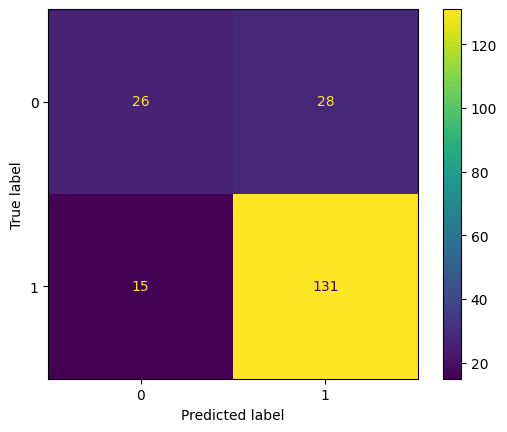

In [49]:
# confusion matrix
conf_mat = metrics.confusion_matrix(y_test, rounded_pred)

# make it more presentable
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0, 1])

cm_display.plot()
plt.show()